# Calibrate the m16 distances for alignment with camera feed
Note: this notebook differs from v1 since we are exploring data with calibrated camera and lidar.

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

First run (front car moving right to left)

In [115]:
data_date = '2018-05-05'
run_number = '0015'
video_file = '/home/robert/PycharmProjects/Einstein/Data/{}/{}.avi'.format(data_date, run_number)
data_file = '/home/robert/PycharmProjects/Einstein/Data/{}/{}.csv'.format(data_date, run_number)
bbox_file = '/home/robert/PycharmProjects/Einstein/Data/Processed/{}/{}.csv'.format(data_date, run_number)
m16_detections1 = pd.read_csv(data_file)
bbox_detections = pd.read_csv(bbox_file)
video_feed1 = cv2.VideoCapture()
video_feed1.open(video_file)

True

In [116]:
m16_detections1.head()

,z1,z2,z3,z4,z5,z6,z7,z8,z9,z10,z11,z12,z13,z14,z15,z16,Unnamed: 16
0,13.038803,13.010574,12.974915,12.610672,19.282639,5.254959,19.252518,5.406326,18.991211,5.168549,5.173477,5.382416,28.264969,5.207077,28.276993,0.000000,NaN
1,13.038803,13.010574,12.974915,12.610672,19.282639,5.254959,19.252518,5.406326,18.991211,5.168549,5.173477,5.382416,28.264969,5.207077,28.276993,0.000000,NaN
2,13.038803,13.010574,12.974915,12.610672,19.282639,5.254959,19.252518,5.406326,18.991211,5.168549,5.173477,5.382416,28.264969,5.207077,28.276993,0.000000,NaN
3,13.039322,13.011337,12.975632,12.578979,19.282272,5.351624,19.251694,5.406189,18.994537,5.164337,18.315399,5.173691,5.381454,28.276001,5.203598,28.276993,NaN
4,13.039322,13.011337,12.975632,12.578979,19.282272,5.351624,19.251694,5.406189,18.994537,5.164337,18.315399,5.173691,5.381454,28.276001,5.203598,28.276993,NaN


In [117]:
consolidated = m16_detections1.copy()
consolidated['bboxes'] = bbox_detections['bboxes']

In [118]:
def get_frame(video_feed, frame_num):
    """Get a single frame from video feed"""
    video_feed.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    _ , frame = video_feed.read()
    return frame

# Let's take a look at the sensor readings

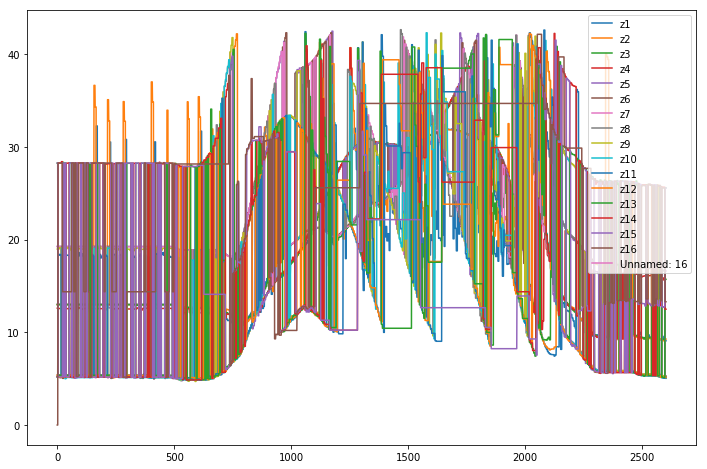

In [119]:
m16_detections1.plot(figsize=(12,8))

## Now take a look at a single sensor

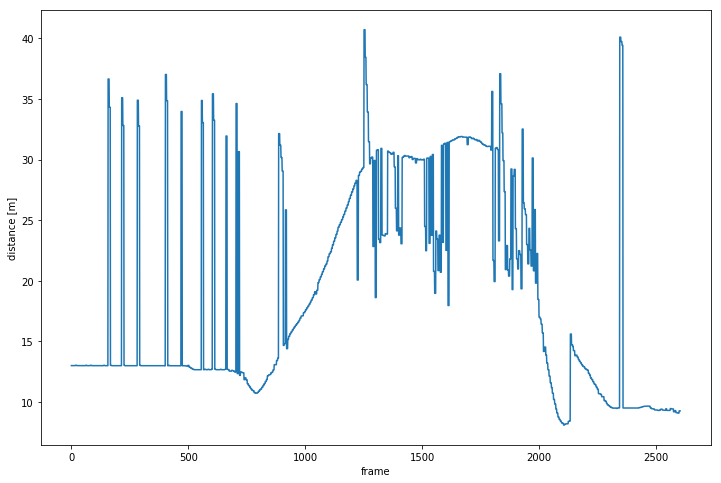

In [120]:
plt.xlabel('frame')
plt.ylabel('distance [m]')
m16_detections1.z2.plot(figsize=(12,8))

Try to smooth out our data.

In [121]:
def despike(yi,th=1.e-8):
    '''Remove spike from array yi, the spike area is where the difference between 
    the neigboring points is higher than th.'''
    y = np.copy(yi) # use y = y1 if it is OK to modify input array
    n = len(y)
    x = np.arange(n)
    c = np.argmax(y)
    d = abs(np.diff(y))
    try:
        l = c - 1 - np.where(d[c-1::-1]<th)[0][0]
        r = c + np.where(d[c:]<th)[0][0] + 1
    except: # no spike, return unaltered array
        return y
    # for fit, use area twice wider then the spike
    if (r-l) <= 3:
        l -= 1
        r += 1
    s = int(round((r-l)/2.))
    lx = l - s
    rx = r + s
    # make a gap at spike area
    xgapped = np.concatenate((x[lx:l],x[r:rx]))
    ygapped = np.concatenate((y[lx:l],y[r:rx]))
    # quadratic fit of the gapped array
    z = np.polyfit(xgapped,ygapped,2)
    p = np.poly1d(z)
    y[l:r] = p(x[l:r])
    return y

In [122]:
def velocity_despike(y, window=1, threshold=10):
    """
    Args:
        y: data to despike
        window: window of velocity values to use during despike
        threshold: velocity threshold in window
    """
    y = y.copy()
    prev = y[0]
    for i in range(1, len(y)):
        abs_vel = abs(prev - y[i])
        if abs_vel > threshold:
            y[i] = prev
        prev = y[i]
    return y
        

# Try Kalman Filter for smoothing
If we use  a constant acceleration model, the spikes should be seen as outliers and "smoothed" as a result

In [123]:
class KalmanFilter1D(object):

    def __init__(self, process_variance, estimated_measurement_variance):
        self.process_variance = process_variance
        self.estimated_measurement_variance = estimated_measurement_variance
        self.posteri_estimate = 0.0
        self.posteri_error_estimate = 1.0

    def input_latest_noisy_measurement(self, measurement):
        priori_estimate = self.posteri_estimate
        priori_error_estimate = self.posteri_error_estimate + self.process_variance

        blending_factor = priori_error_estimate / (priori_error_estimate + self.estimated_measurement_variance)
        self.posteri_estimate = priori_estimate + blending_factor * (measurement - priori_estimate)
        self.posteri_error_estimate = (1 - blending_factor) * priori_error_estimate

    def get_latest_estimated_measurement(self):
        return self.posteri_estimate

0.5716173996377729


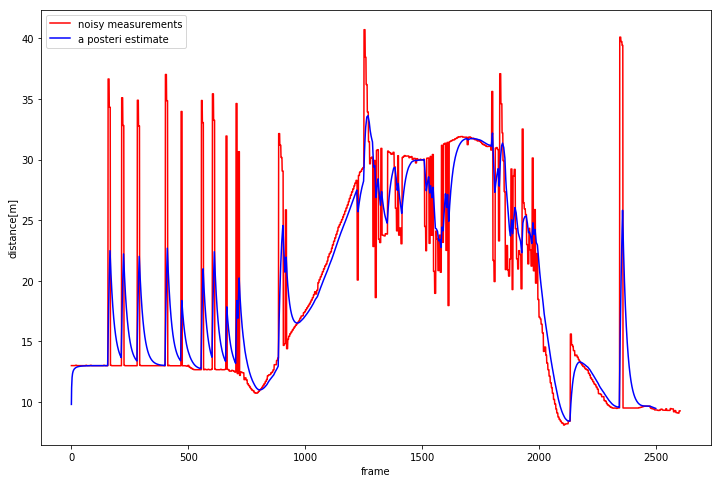

In [124]:
import numpy as np
noisy_measurement = m16_detections1.z2
# in practice we would take our sensor, log some readings and get the
# standard deviation
measurement_standard_deviation = np.std([random.random() * 2.0 - 1.0 for j in xrange(iteration_count)])
print(measurement_standard_deviation)
# The smaller this number, the fewer fluctuations, but can also venture off
# course...
process_variance = 1e-3
estimated_measurement_variance = measurement_standard_deviation ** 2  # 0.05 ** 2
kalman_filter = KalmanFilter1D(process_variance, estimated_measurement_variance)
posteri_estimate_graph = []

for iteration in xrange(1, iteration_count):
    kalman_filter.input_latest_noisy_measurement(noisy_measurement[iteration])
    posteri_estimate_graph.append(kalman_filter.get_latest_estimated_measurement())

plt.figure(figsize=(12,8))
plt.plot(noisy_measurement, color='r', label='noisy measurements')
plt.plot(posteri_estimate_graph, 'b-', label='a posteri estimate')
plt.legend()
plt.xlabel('frame')
plt.ylabel('distance[m]')
plt.show()

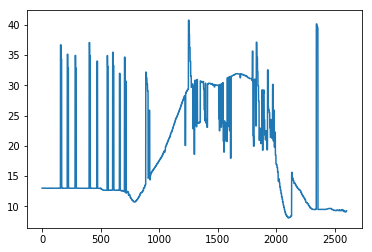

In [125]:
m16_detections1.z2.plot()

8.536236797234524


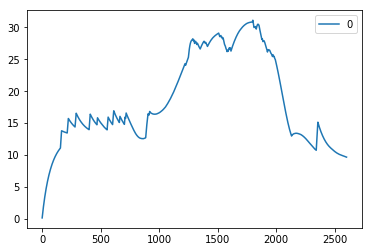

In [126]:
import numpy as np
def kalman_despike(y):
    """
    Use a Kalman Filter to smooth the LiDAR detection signal
    """
    iteration_count = len(y)
    noisy_measurement = y.copy()
    # in practice we would take our sensor, log some readings and get the
    # standard deviation
    measurement_standard_deviation = np.std([random.random() * 2.0 - 1.0 for j in xrange(iteration_count)])
    measurement_standard_deviation = np.std(noisy_measurement)
    print(measurement_standard_deviation)
    # The smaller this number, the fewer fluctuations, but can also venture off
    # course...
    process_variance = 1e-2
    estimated_measurement_variance = measurement_standard_deviation ** 2  # 0.05 ** 2
    kalman_filter = KalmanFilter1D(process_variance, estimated_measurement_variance)
    posteri_estimate_graph = []

    for iteration in xrange(0, iteration_count):
        kalman_filter.input_latest_noisy_measurement(noisy_measurement[iteration])
        posteri_estimate_graph.append(kalman_filter.get_latest_estimated_measurement())
    return posteri_estimate_graph
z2_kal = kalman_despike(y=m16_detections1.z2)
z2_kal = pd.DataFrame(z2_kal)
z2_kal.plot()

8.536236797234524
(2603, 2603)


/home/robert/venv2.7/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=60,center=False).mean()
  


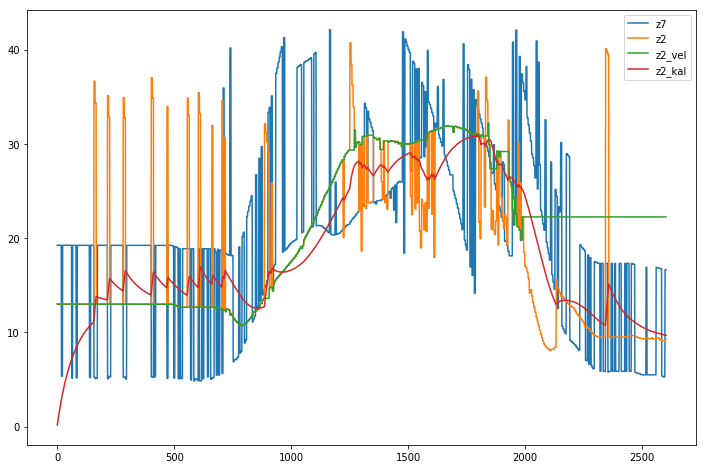

In [170]:
from scipy.interpolate import interp1d
z2_smooth = pd.rolling_mean(m16_detections1.z2, 60)
z2_despike = despike(yi=m16_detections1.z2)
z2_vel = velocity_despike(y=m16_detections1.z2, threshold=3)
z2_kal = kalman_despike(y=m16_detections1.z2)
print(len(z2_kal), len(z2_vel))
m16_detections1['z2_smooth'] = z2_smooth
m16_detections1['z2_despike'] = z2_despike
m16_detections1['z2_vel'] = z2_vel
m16_detections1['z2_kal'] = z2_kal
m16_detections1[['z7', 'z2','z2_vel', 'z2_kal']].plot(figsize=(12,8))

# We've clean from frame 0 to 1500 "good enough" to try bounding box corelation

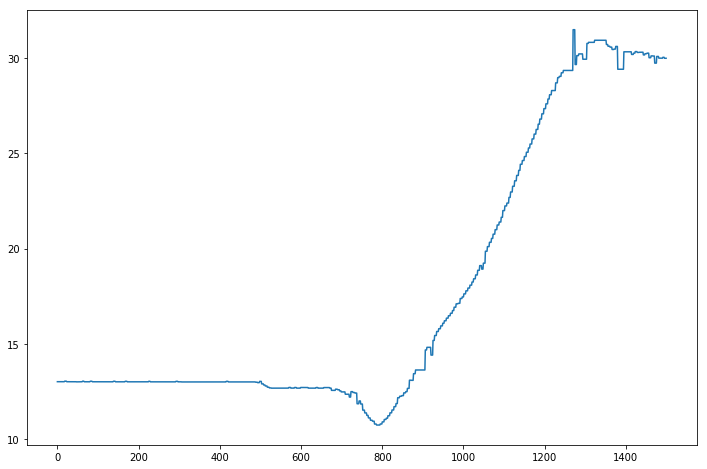

In [166]:
min_idx = 0
max_idx = 1500
z2_clean = m16_detections1[min_idx:max_idx].z2_vel
plt.figure(figsize=(12,8))
z2_clean.plot()

In [162]:
def get_frame_from_video(filename, frame_num):
    vc = cv2.VideoCapture()
    vc.open(filename)
    video_frame = None
    for i in range(frame_num + 1):
        video_frame = vc.read()[1]
    return video_frame

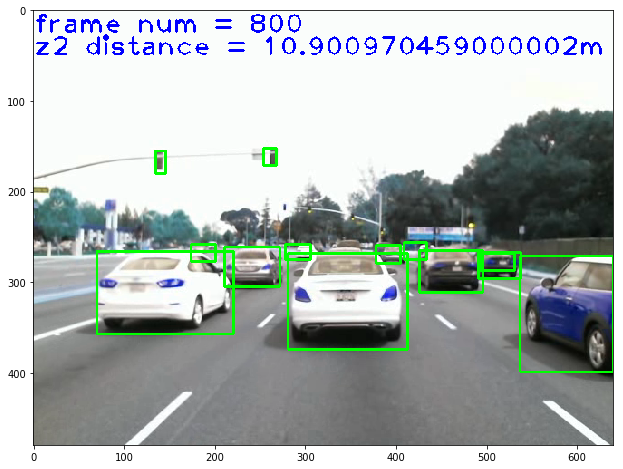

In [165]:
def parse_bbox(bb_str):
    all_bboxes = []
    for bb_s in bb_str.split('_'):
        vals = bb_s.split(' ')
        bbox_list = []
        for v in vals:
            bbox_list.append(int(v))
        all_bboxes.append(bbox_list)
    return all_bboxes

FRAME_NUM = 800
bboxes_clean = bbox_detections[min_idx:max_idx]
bb_ = bboxes_clean.bboxes[FRAME_NUM]
bb_list = parse_bbox(bb_)
video_frame = get_frame_from_video(filename=video_file, frame_num=FRAME_NUM)
# plt.imshow(video_frame)
for bb in bb_list:
    cv2.rectangle(video_frame, (bb[0], bb[1]), (bb[2],bb[3]), (0, 255 ,0), 2)
cv2.putText(video_frame, 'frame num = ' + str(FRAME_NUM), (0, 25), 1, 2, (0,0,255), 2)
cv2.putText(video_frame, 'z2 distance = ' + str(z2_clean[FRAME_NUM]) + 'm', (0, 50), 1, 2, (0,0,255), 2)
plt.figure(figsize=(12,8))
plt.imshow(video_frame)